# RSS default params

self.alpha_lon_accel_max = 3.5 

self.alpha_lon_brake_max = 8.0

self.alpha_lon_brake_min = 4.0

self.alpha_lon_brake_min_correct = 3.0

self.alpha_lat_accel_max = 0.2

self.alpha_lat_brake_min = 0.8

self.lateral_fluctuation_margin = 0.0

self.response_time = 1.0

In [1]:
# from sklearn.cluster import KMeans 
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D

import numpy as np
from matplotlib import cm

import csv
import scipy.stats as stats


import sklearn.cluster
from sklearn.mixture import GaussianMixture
from itertools import combinations
import math

from sklearn.neighbors import KernelDensity

from sklearn import preprocessing

# for interactive plots
%matplotlib inline

# Setting and read all data

In [2]:
#### Names
scenario_names = ['LVM1', 'LVM2', 'LVD', 'LVDAD', 'all']#, 'POV_UnprotectedLeft', 'OppositeVehicleRunningRedLight', 'all']

X1_name = 'alpha_lon_accel_max'
X2_name = 'alpha_lon_brake_max'
X3_name = 'alpha_lon_brake_min'
X4_name = 'response_time'
X5_name = 'alpha_lat_accel_max'
X6_name = 'alpha_lat_brake_min'
X7_name = 'lateral_fluctuation_margin'
X8_name = 'alpha_lon_brake_min_correct'
rob = 'robustness'

var_names = [rob, X1_name, X2_name, X3_name, X4_name]# X5_name, X6_name, X7_name, X8_name]
var_units = ['m', 'm/s^2','m/s^2', 'm/s^2', 's']#, 'm/s^2', 'm/s^2', 'm', 'm/s^2']

## concat all data
data_concat = pd.DataFrame()
data_all = []

##########################################
## whether to check collision data points or not

check_collision = 0

##########################################

for sce in scenario_names[:4]:
    scenario = sce
    print(scenario)
    res_path = "../../results/"+scenario
    
    data_aux = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)
    
    data_collision = data_aux.loc[data_aux[rob] < 0.15]
    data_no_collision = data_aux.loc[data_aux[rob] >= 0.15]
    
    if check_collision:
        data_ = data_collision
    else:
        data_ = data_no_collision
        
    data_all.append(data_)
    
    data_concat = pd.concat([data_concat, data_], ignore_index=True, sort=False)

if check_collision:
    data_concat.to_csv("../../results/all_combined_collision.csv", index=False)
else:
    data_concat.to_csv("../../results/all_combined_no_collision.csv", index=False)
    
# data_collision = data_concat.loc[data_concat[rob] < 0.1]
# data_no_collision = data_concat.loc[data_concat[rob] >= 0.1]

data_all.append(data_concat)
print(len(data_all))

LVM1
LVM2
LVD
LVDAD
5


#### normalize robustness data

In [ ]:
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

X = np.array(data_concat[rob]).reshape(-1, 1)

# Plot the dataframe
# (data_concat[rob]).plot(kind='bar')

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(X)

# Run the normalizer on the dataframe
rob_normalized = pd.DataFrame(x_scaled)

data_concat['robustness'] = rob_normalized

data_all.append(data_concat)

#### Run kmeans and get clusters

LVM1
saving centroids to ../../results/LVM1/LVM1_centroid.csv
Saving labels to ../../results/LVM1/LVM1_param_cluster.csv
points in cluster 0 232
points in cluster 1 5162
 
LVM2
saving centroids to ../../results/LVM2/LVM2_centroid.csv
Saving labels to ../../results/LVM2/LVM2_param_cluster.csv
points in cluster 0 3428
points in cluster 1 198
 
LVD
saving centroids to ../../results/LVD/LVD_centroid.csv
Saving labels to ../../results/LVD/LVD_param_cluster.csv
points in cluster 0 2151
points in cluster 1 849
 
LVDAD
saving centroids to ../../results/LVDAD/LVDAD_centroid.csv
Saving labels to ../../results/LVDAD/LVDAD_param_cluster.csv
points in cluster 0 10230
points in cluster 1 1576
 
all
saving centroids to ../../results/all_centroid.csv
Saving labels to ../../results/all_param_cluster.csv
points in cluster 0 21050
points in cluster 1 2776
 
saving centroids to ../../results/global_centroids.csv


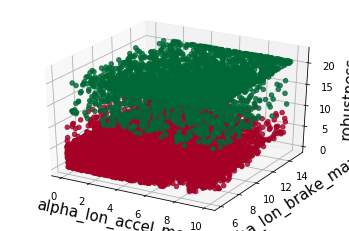

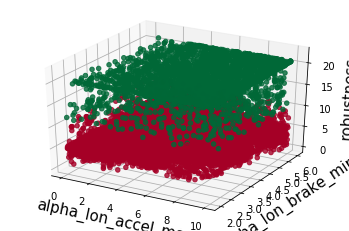

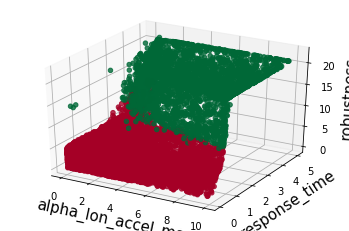

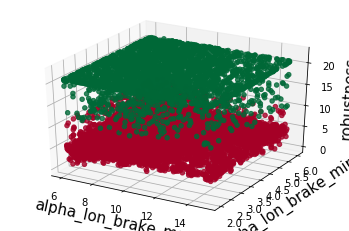

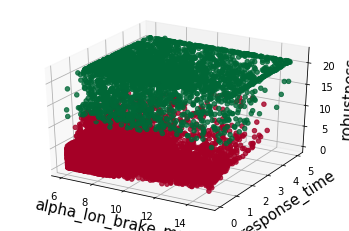

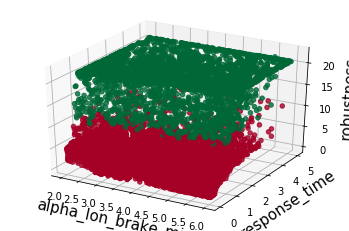

In [3]:
lat_flag = 0
all_flag = 0

if check_collision:
    fn_centroids_all_scenarios = os.path.join("../../results/", 'collision_global_centroids.csv')
else:
    fn_centroids_all_scenarios = os.path.join("../../results/", 'global_centroids.csv')
      
# fh_all_centroids = open(fn_centroids_all_scenarios, 'w')
# writer_all_centroids = csv.writer(fh_all_centroids)
# writer_all_centroids.writerow([rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name])

# centroids_df = pd.DataFrame(columns=[rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name])
centroids_df = pd.DataFrame()

centroids_all = []
data_post_proc = []

for i, data_ in enumerate(data_all):
    
    scenario = scenario_names[i]
    data_ = data_.loc[data_['robustness'] <= 22.0]
    
    if scenario == 'all':
        res_path = "../../results/"
        var_names = [rob, X1_name, X2_name, X3_name, X4_name, 'robustness']
    else:
        res_path = "../../results/"+scenario
    
    if scenario == 'OppositeVehicleRunningRedLight':
        lat_flag = 1
    elif scenario == 'POV_UnprotectedLeft':
        all_flag = 0
    else:
        lat_flag = 0

    if lat_flag:
        var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name]
    elif all_flag:
        var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
    else:
        var_names = [rob, X1_name, X2_name, X3_name, X4_name]

    print(scenario)
    scenario_fn = scenario

    data_ = data_.sort_values(rob)
    if check_collision:
        data = data_
        scenario_fn = scenario + '_collision'

        if scenario == 'all':
            file_name = os.path.join(res_path, scenario_fn + '_combined.csv')
            data.to_csv(file_name, index=False)
        
        clusters = 1
    else:
        data = data_
        clusters = 2
    
    data_desc = data.describe()
    file_name = os.path.join(res_path, scenario_fn + '_desc.csv')
#     fh = open(file_name, 'w')
#     data_desc.to_csv(file_name, index=True)

    min_params = data.iloc[0]
    max_params = data.iloc[-1]
    
    pd.concat([min_params, max_params], axis=1).to_csv(file_name, index=True)
    
    if data.shape[0] > 0:
        ###################################### Run Kmeans
        
        model = sklearn.cluster.KMeans(n_clusters = clusters, n_jobs = 4)
        labels = model.fit_predict(data)
        centroids = model.cluster_centers_
        
        ###################################### concat all scenarios centroids
        centroids_aux = centroids.tolist()
        
        df = pd.DataFrame(centroids_aux, columns = var_names)
        df['scenario'] = [scenario]*clusters
        centroids_df = pd.concat([centroids_df, df], ignore_index=True, sort=False)
        
        ###################################### Save centorids to file
        file_name = os.path.join(res_path, scenario_fn + '_centroid.csv')
        print("saving centroids to", file_name)
        
        res = [var_names] + centroids_aux
#         print("CENTROIDS")
#         print(res)
            
        with open(file_name, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(res)

        ###################################### save data with clusters labels
        file_name = os.path.join(res_path, scenario_fn + '_param_cluster.csv')
        print('Saving labels to', file_name)
        data['cluster_label'] = labels 
        data.to_csv(file_name, index=False)
        data_post_proc.append(data)
        
        for clus in range(0, clusters):
            print('points in cluster',clus, len(data[:][data['cluster_label'] == clus]))
        
        ###################################### save description of clustered data
        df_desc_concat = pd.DataFrame()
        for cl in range(0,clusters):
            df_desc = data.loc[data['cluster_label'] == cl].describe()
            df_desc_concat = pd.concat([df_desc_concat, df_desc])
        
        file_name = os.path.join(res_path, scenario_fn + '_cluster_desc.csv')
        df_desc_concat.to_csv(file_name, index=True)
        
        ###################################### Anova
#         for var in var_names:
#             print(var)
#             print('skew', stats.skew(data[var][data['cluster_label'] == 0]))
#             print('skew', stats.skew(data[var][data['cluster_label'] == 1]))
#             print('skew', stats.skew(data[var][data['cluster_label'] == 2]))
#             print('skew', stats.skew(data[var][data['cluster_label'] == 3]))
#             print('kurtosis', stats.kurtosis(data[var][data['cluster_label'] == 0]))
#             print('kurtosis', stats.kurtosis(data[var][data['cluster_label'] == 1]))
#             print('kurtosis', stats.kurtosis(data[var][data['cluster_label'] == 2]))
#             print('kurtosis', stats.kurtosis(data[var][data['cluster_label'] == 3]))
            
#             cluster_comb = list(combinations(list(range(0, clusters)), 2))
#             for k, cls_l in enumerate(cluster_comb):
#                 print(var, cls_l, stats.f_oneway(data[var][data['cluster_label'] == cls_l[0]],
#                                                   data[var][data['cluster_label'] == cls_l[1]]))
#             print(' ')
        ###################################### Plot 3D graphs
        
        #### Run combination of var for plotting
        comb_names = combinations([X1_name, X2_name, X3_name, X4_name], 2) 
        names_list = list(comb_names)

        R = data[rob]

        ### create plots
        for i, var in enumerate(names_list):
            search_name_x = names_list[i][0]
            search_name_y = names_list[i][1]

            X1 = data[search_name_x]
            X2 = data[search_name_y]

            ## Plot data
            fig = plt.figure(i)
            ax = plt.axes(projection='3d')    

            ax.scatter3D(X1, X2, R, c=labels, cmap=cm.RdYlGn, alpha=0.8)
            ax.set_xlabel(search_name_x, fontsize=15)
            ax.set_ylabel(search_name_y, fontsize=15)
            ax.set_zlabel(rob, fontsize=15)
            plt.tick_params(labelsize=10) 

            figname = os.path.join(res_path, scenario_fn + '_kmeans_' +  search_name_x + '_vs_' + search_name_y + '.pdf')
            plt.savefig(figname, dpi=200)
        
        print(' ')
            

# plt.show()
###################################### save all scnearios centroids to file
print("saving centroids to", fn_centroids_all_scenarios)
centroids_df.to_csv(fn_centroids_all_scenarios, index=True)


#### Boxplots with centroids

#############################################
scenario: LVM1
alpha_lon_accel_max [1.1887536870170634, 1.1887536870170634]
alpha_lon_brake_max [6.65151283986463, 6.65151283986463]
alpha_lon_brake_min [3.9820544703923115, 3.9820544703923115]
response_time [0.2451063976222485, 0.2451063976222485]


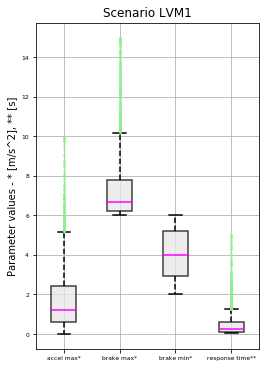

#############################################
scenario: LVM2
alpha_lon_accel_max [3.0269647632160037, 3.0269647632160037]
alpha_lon_brake_max [7.171289680436781, 7.171289680436781]
alpha_lon_brake_min [5.565259517053679, 5.565259517053679]
response_time [0.25291082338607473, 0.25291082338607473]


<Figure size 432x288 with 0 Axes>

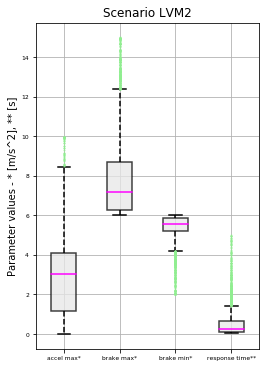

#############################################
scenario: LVDAD
alpha_lon_accel_max [7.71664502592427, 7.71664502592427]
alpha_lon_brake_max [9.364142832549593, 9.364142832549593]
alpha_lon_brake_min [3.5671743138438354, 3.5671743138438354]
response_time [0.5318833971313968, 0.5318833971313968]


<Figure size 432x288 with 0 Axes>

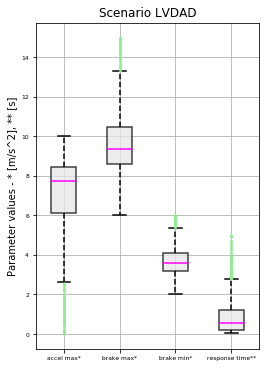

#############################################
scenario: LVD
alpha_lon_accel_max [3.5356423726287405, 3.5356423726287405]
alpha_lon_brake_max [7.826391151048217, 7.826391151048217]
alpha_lon_brake_min [5.389630701460025, 5.389630701460025]
response_time [0.2434743103348679, 0.2434743103348679]


<Figure size 432x288 with 0 Axes>

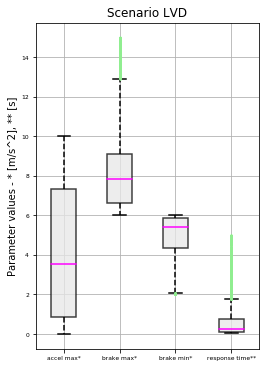

#############################################
scenario: all
alpha_lon_accel_max [3.1311642000586977, 3.1311642000586977]
alpha_lon_brake_max [7.550601930175548, 7.550601930175548]
alpha_lon_brake_min [5.1060962487527695, 5.1060962487527695]
response_time [0.2723528691953382, 0.2723528691953382]


<Figure size 432x288 with 0 Axes>

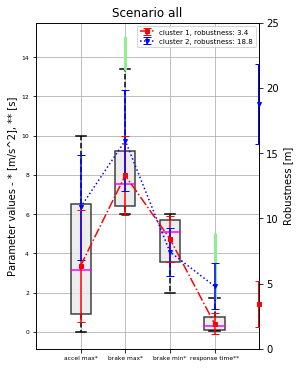

<Figure size 432x288 with 0 Axes>

In [4]:
scenario_names = ['LVM1', 'LVM2', 'LVDAD', 'LVD', 'all']

# var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name]
# var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]

var_names = [rob, X1_name, X2_name, X3_name, X4_name]
var_names_with_units = [rob, 'accel max*', 'brake max*', 'brake min*', 'response time**']

for sce in scenario_names:
    scenario = sce
    sce_index = scenario_names.index(scenario)
    
    if scenario == 'all':
            res_path = "../../results/"
    else:
        res_path = "../../results/"+scenario
        
    data = data_post_proc[sce_index]
    print('#############################################')
    print('scenario:', scenario)

    fig, ax1 = plt.subplots(figsize=(4,6))
#     fig, ax1 = plt.subplots()
    

    ax1.set_ylabel('Parameter values - * [m/s^2], ** [s]')  

    ##### Box plot
    flierprops = dict(markerfacecolor='#90ee90',
                      marker='o', 
                      alpha=0.75, 
                      markersize=2,
                      markeredgecolor='none')
    medianprops = dict(linestyle='-', 
                       linewidth=1.5, 
                       color='magenta')
    boxprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k', 
                    facecolor='#E8E8E8', 
                    alpha=0.75)
    whiskerprops = dict(linestyle='--', 
                        linewidth=1.5, 
                        color='k')
    capprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k')
    ax1.grid(zorder = 1)
    box_plot_desc = ax1.boxplot([data[col] for col in data if col in var_names[1:]], 
                labels=var_names_with_units[1:], 
                boxprops = boxprops,
                capprops = capprops,
                medianprops = medianprops, 
                flierprops = flierprops, 
                whiskerprops = whiskerprops,
                patch_artist = True,
                zorder = 2)
    
    num_boxes = len(var_names[1:])
    medians = np.empty(num_boxes)
    for k in range(num_boxes):
        med = box_plot_desc['medians'][k]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
        print(var_names[k+1], medianY)
    
    ax1.tick_params(labelsize=6)
    ax1.set_title('Scenario '+scenario)
    plot_markers = ['rs-.', 'bv:', 'yo-.', 'g+--']
    color = ['red', 'blue']
    
    if check_collision == 0 and scenario == 'all':
        ax2 = ax1.twinx()
        ax2.set_ylabel('Robustness [m]')  # we already handled the x-label with ax1
        ax2.tick_params(axis='y')
    
    
        ##### clusters plot
        x = np.array(range(1,len(var_names[1:])+1))
        for i in range(0, clusters):

            data_clusters = data.loc[data['cluster_label'] == i]
            cluster_desc = data_clusters.describe()
            if check_collision:
                cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + '_cluster_desc_collision.csv'), index=True)
            else:
                cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + '_cluster_desc_no_collision.csv'), index=True)
    
            data_desc = data_clusters.describe()
            y = data_desc.loc['mean']
            std = data_desc.loc['std']

            y = y.tolist()
            y_ = np.array(y)

            std = std.tolist()
            std_ = np.array(std)

            rob_y = y_[0]
            rob_std = std_[0]
            rob_x = [5]
            ax2.axis([0,5, 0, 25])
            ax2.errorbar(rob_x, y=rob_y, yerr=rob_std, fmt=plot_markers[i],linewidth=3,markersize=4, capsize=4, zorder=20, clip_on=False)


            ax1.errorbar(x, y_[1:-1], yerr=std_[1:-1], fmt=plot_markers[i], capsize=4,markersize=4, clip_on=False, label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)
            ax1.legend(loc='upper right', fontsize=7)

    if check_collision:
        figname = os.path.join(res_path, scenario + '_boxplot_collision.pdf')
    else:
        figname = os.path.join(res_path, scenario + '_boxplot_no_collision.pdf')
    
    
    plt.savefig(figname, dpi=200, bbox_inches='tight')
    plt.show()
    plt.tight_layout()
    


In [ ]:
box_plot_desc['medians'][0].details

In [ ]:
stats.f_oneway(data[X1_name], data[X2_name], data[X3_name], data[X4_name])

#### Kernel Density Estimation
https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

In [ ]:
samples = data_no_collision
var_names = [X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name] #, X8_name]

for i, var in enumerate(var_names):
    print(var)
    X = samples[var].dropna()
    X = np.array(X)
    if X.shape[0] > 0:
        print(X.shape)

        X = X.reshape(-1, 1)
        N = X.shape[0]

        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

        max_point = X.max()
        
        X_plot = np.linspace(0, max_point, 3000)[:, None]

        log_dens = kde.score_samples(X_plot)
        
        fig = plt.figure(i, figsize=(7,4))
        ax = fig.subplots()
        ax.plot(X_plot[:, 0], np.exp(log_dens), color = 'black', linestyle='-', label="KDE {0}, {1} pts".format(var, N))

        ax.legend(loc='upper right')        
        ax.set_xlabel(var + ' [' + var_units[i] + ']', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)

        if check_collision:
            figname = os.path.join("../../results", 'all_collision_kde_' +  var + '.pdf')
        else:
            figname = os.path.join("../../results", 'all_no_collision_kde_' +  var + '.pdf')
                
        plt.savefig(figname, dpi=200)
        
#         plt.show()
    else: 
        print(var, 'no collision')

# Experimental

In [ ]:
data = data_concat.sort_values('robustness')
min_params = data.iloc[0]
max_params = data.iloc[-1]
median_params = data.iloc[int(data.shape[0]/2)]
#     mean_params = data.loc[data['robustness'] == mean]
var_names = [rob, X1_name, X2_name, X3_name, X4_name]

print("min robustness")
print(min_params)
print("max robustness")
print(max_params)
print("median robustness")
print(median_params)

fig, ax1 = plt.subplots(figsize=(6,10))
data.loc[:, [X1_name, X2_name, X3_name, X4_name]].boxplot(rot=45)
ax2 = ax1.twinx()
ax2.set_ylabel('Robustness normalized')

        
#     ########### min max and median
ax1.plot(list(range(1, len(var_names[1:])+1)), max_params[1:], '*c--', label="max robustness: {0:.3f}".format(max_params[0]))
ax1.legend(loc='upper right')

# ax1.plot(list(range(1, len(var_names[1:])+1)), median_params[1:], 'sr-', label="median robustness: {0:.3f}".format(median_params[0]))
# ax1.legend(loc='upper right')

ax1.plot(list(range(1, len(var_names[1:])+1)), min_params[1:], 'vm-.', label="min robustness: {0:.3f}".format(min_params[0]))
ax1.legend(loc='upper right')

res_path = "../../results/"
if check_collision:
    figname = os.path.join(res_path, "longitudinal_all" + '_boxplot_collision.pdf')
else:
    figname = os.path.join(res_path, "longitudinal_all" + '_boxplot_no_collision.pdf')
    
plt.savefig(figname, dpi=200)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array(data_concat)
X_embedded = TSNE(n_components=3, perplexity=30, init='pca', n_iter_without_progress=100).fit_transform(X)
print(X_embedded.shape)

In [ ]:
scenario_names = ['LVM1', 'LVM2', 'LVDAD', 'LVD', 'POV_UnprotectedLeft']
scenario = scenario_names[1]
# print(scenario)
#
res_path = "../../results/"+scenario

X1_name = 'alpha_lon_accel_max'
X2_name = 'alpha_lon_brake_max'
X3_name = 'alpha_lon_brake_min'
X4_name = 'response_time'

# Read data from a csv to pandas data frame
data = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)

In [ ]:
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0,0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, renderer.M)
        self.xy=(x2,y2)
        super().draw(renderer)


def _annotate3D(ax,text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation= Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D,'annotate3D',_annotate3D)

In [ ]:
search_name_x = "alpha_lon_brake_min"
search_name_y = 'alpha_lon_brake_max'
rob = 'robustness'
X1 = data[search_name_x]
X2 = data[search_name_y]
R = data[rob]

In [ ]:
## concatenate data from all scenarios
concat_flag = 1

data_all = pd.DataFrame()

data = []
for sce in scenario_names:
    print(sce)
    scenario = sce
    res_path = "../../results/"+scenario
    data_aux = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)
    data.append(data_aux)
    
    if concat_flag:
        print("concatenation of all scenarios")
        data_all = pd.concat([data_all, data], ignore_index=True)
        scenario = "all"
        res_path = "../../results/"
        
        data.append(data_all)

# Run Kmeans

In [ ]:

clusters = 3

kmeans = KMeans(n_clusters = clusters, n_jobs=4) 
kmeans.fit(data) 

km_labels = kmeans.labels_
km_centers = kmeans.cluster_centers_

# Create the pandas DataFrame  
km_centers_df = pd.DataFrame(km_centers, columns = [X1_name, X2_name, X3_name, X4_name, 'robustness'])
print(df)
print((km_labels))

data['cluster_label'] = km_labels
data = data.sort_values(by=['cluster_label'])

data.to_csv(os.path.join(res_path, scenario + '_param_cluster.csv'), index=False)

In [ ]:
### Plot kmeans centroids

ax = plt.axes(projection='3d')    
fontsize =15
ax.scatter3D(X1, X2, R, c=R, cmap=cm.RdYlGn, alpha=0.3)
ax.set_xlabel(search_name_x, fontsize=fontsize)
ax.set_ylabel(search_name_y, fontsize=fontsize)
ax.set_zlabel('Robustness', fontsize=fontsize)
plt.tick_params(labelsize=10) 

ax.scatter3D(km_centers_df[search_name_x], km_centers_df[search_name_y], km_centers_df[rob], marker='o', s=1000, c='magenta')

for i, txt in enumerate(km_centers_df[rob]):
    print(txt)
    
#     ax.text(km_centers_df[search_name_x].iloc[i], km_centers_df[search_name_y].iloc[i]
#             , km_centers_df[rob].iloc[i], str(km_centers_df[rob].iloc[i]), color='black')
    
    ax.annotate3D(str(km_centers_df[rob].iloc[i])[:5],
                  (km_centers_df[search_name_x].iloc[i], km_centers_df[search_name_y].iloc[i], km_centers_df[rob].iloc[i]),
                  xytext=(-100,60),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=2))
    
    
plt.show()

# Experimental

In [ ]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
model = pca.fit(data) 

pca_data = pd.DataFrame(pca.transform(data)) 

print(model.singular_values_)


from matplotlib import colors as mcolors 
import math 

''' Generating different colors in ascending order of their hsv values '''
colors = list(zip(*sorted((tuple(mcolors.rgb_to_hsv(
    mcolors.to_rgba(color)[:3])), name)
                           for name, color in dict( 
                               mcolors.BASE_COLORS, **mcolors.CSS4_COLORS
                           ).items())))[1] 


# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 



In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
%matplotlib qt

fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[1], pca_data[2], pca_data[0], 
           c = list(map(lambda label : cluster_colors[label], 
                        kmeans.labels_))) 

str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

# list(map(lambda data1, data2, data3, str_label:
#          ax.text(data1, data2, data3, s = str_label, size = 20,
#                  zorder = 20, color = 'k'), pca_data[0], pca_data[1],
#          pca_data[2], str_labels)) 

plt.show() 
